# Grover Algorithm with Shrinking of the Space

We look at our example implementation for the expression:

$$
    \mathcal{R}(x_1, \bar{x}_2, x_3) \land \mathcal{R}(x_2, \bar{x}_3, x_4) \land \mathcal{R}(\bar{x}_3, \bar{x}_4, x_5)
$$

The script can be used to solve any 1-in-3 SAT instance. The input variables in the beginning therefore have to be changed.

In [22]:
import qiskit
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate 
from numpy import pi

Input variables

In [23]:
expr = np.array([[1, -2, 3], [2, -3, 4], [-3, -4, 5]])
null_space = np.array([[1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1]], dtype=object)
xi_bar = np.array([0, 1, 1, 0, 0], dtype=object)

k = 2 # dim kernel
n = 5 # n variables
m = 3 # num of clauses
m_upper = math.ceil(math.log2(m+1))
num_assignments = 2**k

In [24]:
def transform_expression(expression):
    new_repr = []
    for clause in expression:
        new_repr.append((False, [(True, abs(var) - 1) if var < 0 else (False, var - 1) for var in clause]))
    return new_repr

In [25]:
expression = transform_expression(expr)
print(expression)

[(False, [(False, 0), (True, 1), (False, 2)]), (False, [(False, 1), (True, 2), (False, 3)]), (False, [(True, 2), (True, 3), (False, 4)])]


In [26]:
def shrink_space(null_space, k, n):
    """
    Create a circuit to shrink the space.
    """
    xor_v_var = QuantumRegister(k, name = 'v')
    xor_x_var = QuantumRegister(n, name = 'x')
    xor_sol_space = QuantumCircuit(xor_v_var, xor_x_var, name='XOR sol space')

    # null_space gets initialized
    for i in range(k):
        for j in range(n):
            if null_space[i][j] == 1: 
                xor_sol_space.cx(v_var[i], x_var[j])
        xor_sol_space.barrier()

    # xi_bar is initialized
    for i in range(n):
        if xi_bar[i] == 1:
            xor_sol_space.x(x_var[i])
    xor_sol_space.barrier()
    
    return xor_sol_space

In [27]:
def reversed_shrink_space(null_space, k, n):
    """
    Undos the manipulation of the x vars to uncompute the shrinking of the space.
    """
    xor_v_var = QuantumRegister(k, name = 'v')
    xor_x_var = QuantumRegister(n, name = 'x')
    xor_sol_space = QuantumCircuit(xor_v_var, xor_x_var, name='XOR sol space uncomp')

    # xi_bar uncomputation
    for i in range(n):
        if xi_bar[i] == 1:
            xor_sol_space.x(x_var[i])
    xor_sol_space.barrier()    
    
    # null_space uncomputation
    for i in reversed(range(k)):
        for j in reversed(range(n)):
            if null_space[i][j] == 1: 
                xor_sol_space.cx(v_var[i], x_var[j])
        xor_sol_space.barrier()
    
    return xor_sol_space

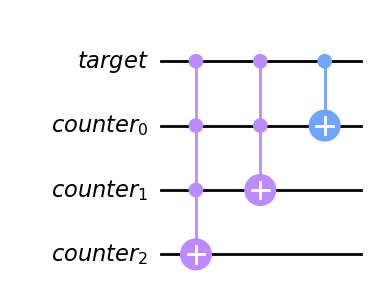

In [28]:
def get_toffoli_counter(m_upper):
    """
    counts +1 for the counting qubits if a clause is satisfied
    """
    q_var = QuantumRegister(m_upper, name='counter')
    q_target = QuantumRegister(1, 'target')
    counter = QuantumCircuit(q_target, q_var, name='counter')  
    
    for i in range(m_upper):
        counter.append(MCXGate(m_upper-i), q_target[0:]+q_var[0:m_upper-i])
    return counter

get_toffoli_counter(3).draw('mpl')

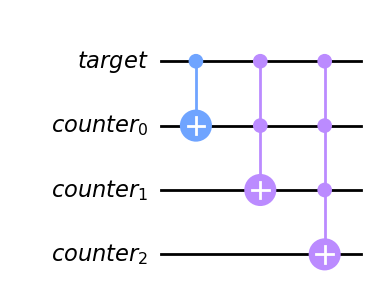

In [29]:
def get_reverse_toffoli_counter(m_upper):
    """
    counts -1 for the counting qubits if a clause is satisfied
    """
    q_var = QuantumRegister(m_upper, name='counter')
    q_target = QuantumRegister(1, name='target')
    counter = QuantumCircuit(q_target, q_var, name='rev_counter')  
    
    for i in range(m_upper):
        counter.append(MCXGate(i+1), q_target[0:]+q_var[0:(i+1)])
    return counter

get_reverse_toffoli_counter(3).draw('mpl')

In [30]:
def get_oracle(expression, n, m_upper, m):
    """
    oracle for 1in3-SAT expression. Every clause i is satisfied if w_i is in state 1. We compute that by taking 
    clause i = (x1, x2, x3) and compute the xor-sum x1 + x2 + x3 + (x1 and x2 and x3) which result we safe in w_i. 
    The xor-sum is 1 if and only if exactly one variable is true.
    """
    m = len(expression)
    x_vars = QuantumRegister(n, name='x')
    w_var = QuantumRegister(1, name='w')
    counter_vars = QuantumRegister(m_upper, name='counter')
    oracle = QuantumCircuit(x_vars, w_var, counter_vars, name='oracle')
    
    for i, val in enumerate(expression):
        nc, clause = val
        for nv, var_index in clause:
            if nv:
                oracle.x(x_vars[var_index])        
        oracle.barrier()
                
        clause_qubits = [x_vars[var_index] for nv, var_index in clause] 
        
        if len(clause_qubits) == 3:
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [w_var[0]])       
        
        for clause_qubit in clause_qubits:
            oracle.cx(clause_qubit, w_var[0])
        
        # counter 
        oracle.append(get_toffoli_counter(m_upper), w_var[0:] + counter_vars[0:])
            
        for clause_qubit in reversed(clause_qubits):
            oracle.cx(clause_qubit, w_var[0])
        
        if len(clause_qubits) == 3:
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [w_var[0]]) 
        
        oracle.barrier()
        
        for nv, var_index in clause:
            if nv:
                oracle.x(x_vars[var_index])        
        oracle.barrier()       
        
    return oracle

In [31]:
def get_reversed_oracle(expression, n, m_upper, m):
    """
    oracle for 1in3-SAT expression. Every clause i is satisfied if w_i is in state 1. We compute that by taking 
    clause i = (x1, x2, x3) and compute the xor-sum x1 + x2 + x3 + (x1 and x2 and x3) which result we safe in w_i. 
    The xor-sum is 1 if and only if exactly one variable is true.
    """
    m = len(expression)
    x_vars = QuantumRegister(n, name='x')
    w_var = QuantumRegister(1, name='w')
    counter_vars = QuantumRegister(m_upper, name='counter')
    oracle = QuantumCircuit(x_vars, w_var, counter_vars, name='rev_oracle')
    
    for i, val in enumerate(reversed(expression)):
        nc, clause = val
        for nv, var_index in clause:
            if nv:
                oracle.x(x_vars[var_index])        
        oracle.barrier()
                
        clause_qubits = [x_vars[var_index] for nv, var_index in clause]
        
        if len(clause_qubits) == 3:
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [w_var[0]])       
        
        for clause_qubit in clause_qubits:
            oracle.cx(clause_qubit, w_var[0]) 
        
        # counter 
        oracle.append(get_reverse_toffoli_counter(m_upper), w_var[0:] + counter_vars[0:])
        
        for clause_qubit in reversed(clause_qubits):
            oracle.cx(clause_qubit, w_var[0])
        
        if len(clause_qubits) == 3:
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [w_var[0]]) 
        
        oracle.barrier()
        
        for nv, var_index in clause:
            if nv:
                oracle.x(x_vars[var_index])        
        oracle.barrier()       
        
    return oracle

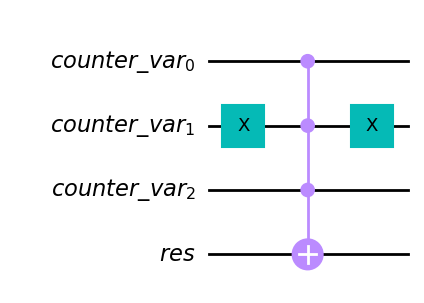

In [32]:
def get_result(m_upper, m):
    counter_vars = QuantumRegister(m_upper, name = 'counter_var')
    res_var = QuantumRegister(1, name = 'res')
    qc = QuantumCircuit(counter_vars, res_var, name='get_result')
    
    for c_num, j in enumerate(bin(m)[2:][::-1]):
        if int(j) == 0:
            qc.x(counter_vars[c_num])

    if len(bin(m)[2:]) < m_upper:
        for i in range(m_upper - len(bin(m)[2:])):
            qc.x(counter_vars[m_upper-1-i])
    
    qc.append(MCXGate(m_upper), counter_vars[0:] + [res_var[0]])
    
    if len(bin(m)[2:]) < m_upper:
        for i in range(m_upper - len(bin(m)[2:])):
            qc.x(counter_vars[m_upper-1-i])

    for c_num, j in enumerate(bin(m)[2:][::-1]):
        if int(j) == 0:
            qc.x(counter_vars[c_num])
    
    return qc

get_result(3, 5).draw('mpl')

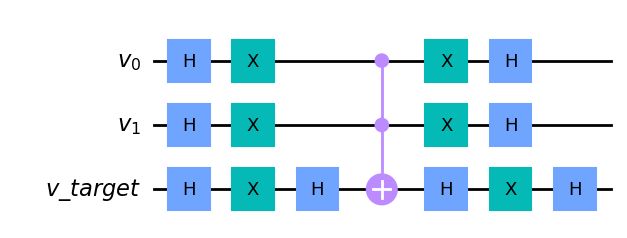

In [33]:
 def get_diffuser(k):
    """
    Amplifies the solution(s). We safe the result of the expression (1 True, 0 False) in res_var[-1] which
    gets checked.
    """
    q_var = QuantumRegister(k, name='v')
    q_target = QuantumRegister(1, name='v_target')
    diffuser = QuantumCircuit(q_var, q_target, name='diffuser')    
    diffuser.h(q_var)
    diffuser.x(q_var)
    diffuser.h(q_target)
    diffuser.x(q_target)
    diffuser.h(q_target)
    diffuser.append(MCXGate(k), q_var[0:]+q_target[0:])
    diffuser.h(q_target)
    diffuser.x(q_target)
    diffuser.h(q_target)
    diffuser.x(q_var)
    diffuser.h(q_var)
    return diffuser

get_diffuser(2).draw('mpl')

In [34]:
v_var = QuantumRegister(k, 'v')
x_var = QuantumRegister(n, 'x')
a_var = QuantumRegister(1, 'a')
w_var = QuantumRegister(1, 'w')
counter_vars = QuantumRegister(m_upper, 'counter')
res_var = QuantumRegister(1, 'res')
answer_var = ClassicalRegister(k, 'answer') # want to measure v and the q_checker if the 3SAT problem is satisfied
sat_solver = QuantumCircuit(v_var, x_var, a_var, w_var, counter_vars, res_var, answer_var)

In [35]:
num_solutions = 1
repetitions = math.floor(math.pi/4 * math.sqrt(2**k)/num_solutions)

sat_solver.h(v_var)

sat_solver.x(res_var)
sat_solver.h(res_var)

sat_solver.barrier()

for i in range(repetitions): #
    sat_solver.append(shrink_space(null_space, k, n), v_var[0:] + x_var[0:])
    sat_solver.barrier()
    sat_solver.append(get_oracle(expression, n, m_upper, m), x_var[0:] + w_var[0:] + counter_vars[0:])
    sat_solver.barrier()
    
    sat_solver.append(get_result(m_upper, m), counter_vars[0:] + res_var[0:])
    sat_solver.barrier()
    
    sat_solver.append(get_reversed_oracle(expression, n, m_upper, m), x_var[0:] + w_var[0:] + counter_vars[0:])
    sat_solver.barrier()
    sat_solver.append(reversed_shrink_space(null_space, k, n), v_var[0:] + x_var[0:])
    sat_solver.barrier()
    sat_solver.append(get_diffuser(k-1), v_var[0:])

In [36]:
for i in range(k):
    sat_solver.measure(v_var[i], i)

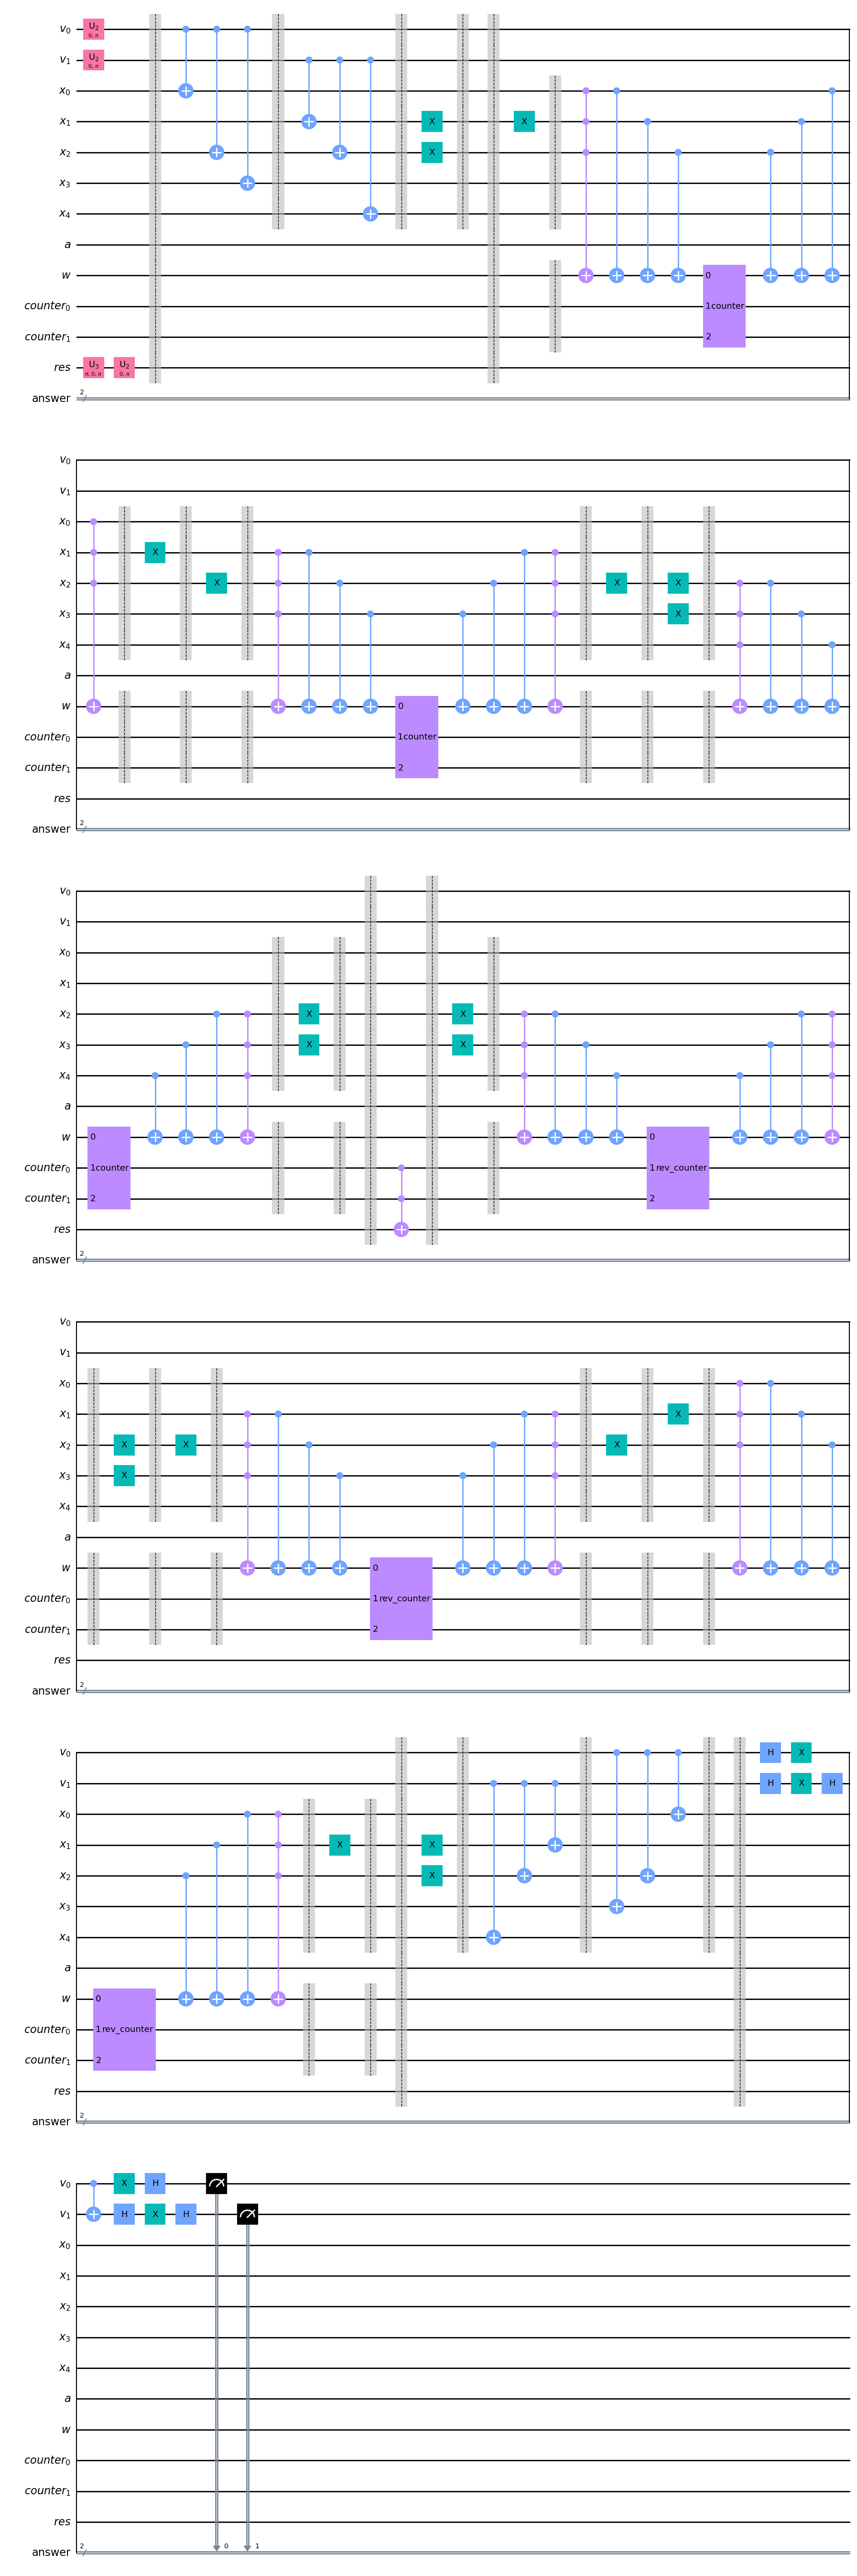

In [37]:
sat_solver.decompose().draw('mpl') 

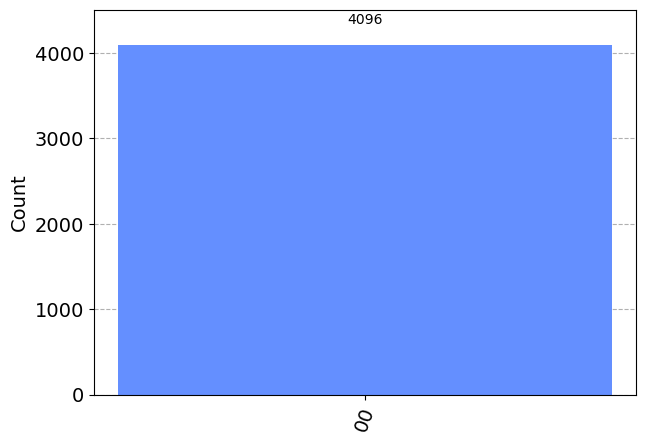

In [38]:
num_shots = 4096

simulator = BasicAer.get_backend('qasm_simulator')
result = execute(sat_solver, simulator, shots=num_shots).result()
counts = result.get_counts(sat_solver)  
plot_histogram(counts) 

In [39]:
mean = num_shots / num_assignments
confidence_rate = 1.5

solutions = [key for key, value in counts.items() if value > int(confidence_rate * mean)]
solutions = [solution[::-1] for solution in solutions]
print(solutions)

['00']


In [41]:
import itertools

binary_combinations = list(itertools.product([0, 1], repeat=k))

# create subspace with all possible solutions to the XOR-SAT problem
subspace = np.tile(xi_bar, (2 **k, 1)) 
for i, binary_combi in enumerate(binary_combinations):
    for pos, var in enumerate(binary_combi):
        subspace[i, :] += var * null_space[pos]
subspace = subspace % 2

def varify_clause_q_in_p_SAT(assignment, expression, q):    
    for i, val in enumerate(expression):
        counter = 0
        nc, clause = val
        for nv, var_index in clause:
            if nv:
                if assignment[var_index] == 0:
                    counter += 1
            else:
                if assignment[var_index] == 1:
                    counter += 1
        if counter != q:
            return f'False: error in clause {i}.'
    return 'True.'

# Check for a certain binary combination if the assignment satisfies the expression
# 10 here means 01 in the output of the program!

for solution in solutions:
    tested_expr_index = int(solution, 2)
    tested_expr = subspace[tested_expr_index] 
    print(tested_expr)
    print(varify_clause_q_in_p_SAT(tested_expr, expression, 1))

[0 1 1 0 0]
True.
